In [11]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tqdm
import torch
from torch import tensor, Tensor
from typing import Any

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import block_formats.experiments as E
matplotlib.rcParams.update({"axes.spines.top": False, "axes.spines.right": False, "legend.frameon": False})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
model = "google/gemma-3-1b-pt"  # compare with "meta-llama/Llama-3.2-1B"
fisher_sum, = [run.summary.fisher for run in E.runs("20250423-fisher") if run.config.model == model]
# fisher_sum_rerun, = [run.summary.fisher for run in E.runs("20250503-fisher-gemma") if run.config.model == model]  # repeated, with same issue
weight_stats, = [run.summary.weight_stats for run in E.runs("20250423-weight-stats") if run.config.model == model]
runs = [run for run in E.runs("20250502-noise-sensitivity") if run.config.model == model]

In [17]:
def get_row(run: E.AttrDict) -> dict[str, Any]:
    if run.meta.status == "finished" and "vision_model" not in run.config.test.parameter and "multi_modal_projector" not in run.config.test.parameter:
        return dict(
            scale=run.config.test.scale,
            parameter=run.config.test.parameter,
            fisher_sum=fisher_sum[run.config.test.parameter],
            rm2=weight_stats[run.config.test.parameter].rm2,
            kl_div=tensor(run.summary.kl_div).mean().item(),
        )

df = pd.DataFrame.from_records(filter(None, map(get_row, runs)))
df["kl_div_prediction"] = 0.5 * (df.scale * df.rm2) ** 2 * df.fisher_sum
df.head()

,scale,parameter,fisher_sum,rm2,kl_div,kl_div_prediction
0,0.25,model.embed_tokens.weight,442766.910,0.030839,0.193627,13.159450
1,0.25,model.layers.0.self_attn.q_proj.weight,31909.271,0.025781,0.001459,0.662777
2,0.25,model.layers.0.self_attn.k_proj.weight,35367.324,0.033672,0.001640,1.253145
3,0.25,model.layers.0.self_attn.v_proj.weight,179047.250,0.033672,0.002667,6.343967
4,0.25,model.layers.0.self_attn.o_proj.weight,546594.250,0.018759,0.002823,6.010875


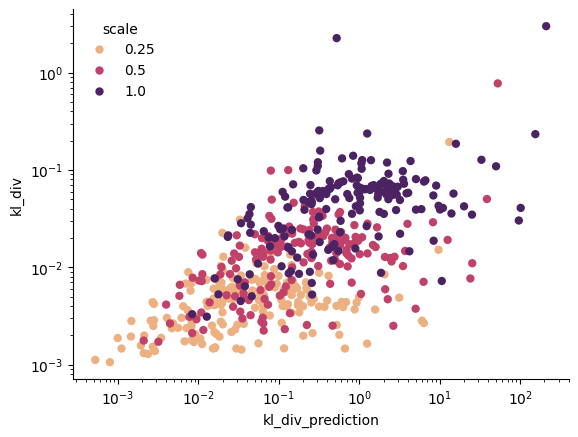

In [18]:
ax = sns.scatterplot(df, y="kl_div", x="kl_div_prediction", hue="scale", hue_norm=matplotlib.colors.LogNorm(), palette="flare", lw=0)
ax.set_xscale("log")
ax.set_yscale("log")